In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from datetime import datetime
!pip install dataretrieval
from dataretrieval import nwis
import random
# Set seeds for all major libraries
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# --- 1. Generate Sample Data (Replace with your actual DataFrame) ---
# Assuming your DataFrame 'df' is already loaded.
# For demonstration, let's create a sample DataFrame:
#np.random.seed(42) # for reproducibility
#dates = pd.to_datetime(pd.date_range(start='2020-01-01', periods=200, freq='D'))
#x1 = np.sin(np.linspace(0, 50, 200)) + np.random.rand(200) * 0.5
#x2 = np.cos(np.linspace(0, 40, 200)) * 0.8 + np.random.rand(200) * 0.3
#y = 0.7 * x1 + 0.3 * x2 + np.sin(np.linspace(0, 60, 200)) * 0.5 + np.random.rand(200) * 0.2
#df = pd.DataFrame({'date': dates, 'x1': x1, 'x2': x2, 'y': y})

#print("Sample DataFrame Head:")
#print(df.head())
#print("\nDataFrame Info:")
#df.info()

In [3]:
# Get the current time
current_time = datetime.now()

# Print the current time
print("Current time:", current_time)
startDate = "1995-10-01"
endDate = "2024-09-30"
model_site = [
            '13176400' #'13310850' #'13340000'#'13176400' #"12305000"#"13311450" # "13296000"
]
units_day = 365
missing_data_threshold = 0.90 *365

summer_months = [6,7,8]
summer_missing_data_threshold = 0.90 * (30+31+31)

site_info = nwis.get_info(sites= model_site )
site_info_df = pd.DataFrame( site_info[0] )
print("site_info_df:",site_info_df)
print("station_nm:",site_info_df['station_nm'][0])
site_info_df["site_no"]=site_info_df["site_no"].astype(str)
columns_to_save = ['site_no', 'station_nm','dec_lat_va', 'dec_long_va', 'drain_area_va', 'contrib_drain_area_va' ,   'alt_va'
                  # ,'alt_meth_cd', 'alt_acy_va', 'alt_datum_cd'
                  ]
filtered_df = site_info_df[columns_to_save]



parameterCode = ["00010","00060"  ]
dailyStreamtemp = nwis.get_dv(sites= model_site
                              , parameterCd=parameterCode, start=startDate, end=endDate)
dailyStreamtemp_df = pd.DataFrame( dailyStreamtemp[0] )
dailyStreamtemp_df = dailyStreamtemp_df.reset_index()
dailyStreamtemp_df['Date'] = dailyStreamtemp_df['datetime'].dt.date
dailyStreamtemp_df['Month'] = dailyStreamtemp_df['datetime'].dt.month
dailyStreamtemp_df['Year'] = dailyStreamtemp_df['datetime'].dt.year

shared_url = "https://drive.google.com/file/d/1z9w4rk21CCbbuOjwsru1pgkiOsYgVX6h/view?usp=share_link"
file_id = shared_url.split('/d/')[1].split('/')[0]
download_url = f"https://drive.google.com/uc?id={file_id}"
prism_df = pd.read_csv(download_url)
prism_df['date'] = pd.to_datetime( prism_df['date'])

def days_since_october_first(date):
    october_first = pd.Timestamp(year=date.year, month=10, day=1)
    days_difference = (date - october_first).days
    return days_difference if days_difference >= 0 else days_difference + 365

prism_df['Days_Since_October_1st'] =  prism_df['date'].apply(days_since_october_first)
#prism_df[ "rad_d"   ] = 2 * np.pi * prism_df[ "Days_Since_October_1st"   ] /365
prism_df["site_no"] =prism_df["site_no"].astype(str)
# Add a leading 0 to strings with exactly 7 characters
prism_df['site_no'] = prism_df['site_no'].apply(lambda x: '0' + x if len(x) == 7 else x)
prism_df["site_no"] =prism_df["site_no"].astype(str)
#print( prism_df)
prism_df['Date'] = prism_df['date'].dt.date

prism_df = prism_df[['tmean' , "site_no", 'Date'
#, "rad_d"
 ]]

dailyStreamtemp_df = dailyStreamtemp_df[[    'Date',
       'site_no',
  '00010_Mean', '00060_Mean'
  #,      'Month', 'Year'
   ]]

result = pd.merge(prism_df, dailyStreamtemp_df, on=['Date','site_no'], how='inner')

# Count the number of NaN values in each column
na_count = result.isna().sum()

# Drop rows with any NaN values
df_cleaned = result.dropna()

df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])

train_month = [ 6, 7, 8]

df_cleaned= df_cleaned[ df_cleaned['Date'].dt.month.isin( train_month )]

# Print the cleaned DataFrame
print(df_cleaned)

# Count the number of NaN values in each column
na_count = df_cleaned.isna().sum()

print(na_count)

Current time: 2025-05-12 04:12:08.533945
site_info_df:   agency_cd   site_no                                station_nm site_tp_cd  \
0      USGS  13176400  EF OWYHEE RIVER AT CRUTCHER CROSSING, ID         ST   

      lat_va     long_va  dec_lat_va  dec_long_va coord_meth_cd  coord_acy_cd  \
0  421540.93  1165206.39   42.261369  -116.868442             N             1   

   ... reliability_cd gw_file_cd  nat_aqfr_cd  aqfr_cd  aqfr_type_cd  \
0  ...            NaN   NNNNNNNN          NaN      NaN           NaN   

  well_depth_va hole_depth_va depth_src_cd  project_no  \
0           NaN           NaN          NaN         NaN   

                      geometry  
0  POINT (-116.86844 42.26137)  

[1 rows x 43 columns]
station_nm: EF OWYHEE RIVER AT CRUTCHER CROSSING, ID
          tmean   site_no       Date  00010_Mean  00060_Mean
178   15.837001  13176400 2013-06-01        17.0        75.6
179   15.473001  13176400 2013-06-02        18.4        73.1
180   14.406001  13176400 2013-06-03  

<ipython-input-3-09571f37046c>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])


In [4]:
#features = ['x1', 'x2']
#target = 'y'
# Normalize the data
# It's crucial to normalize all input features and the target variable for LSTMs.
# We'll use a separate scaler for the target 'y' to easily inverse transform predictions.
#scaler_features = MinMaxScaler(feature_range=(0, 1))
#scaler_target = MinMaxScaler(feature_range=(0, 1))

# Fit and transform features
#df[features] = scaler_features.fit_transform(df[features])

# Fit and transform target
# Reshape for scaler (expects 2D array)
#df[target] = scaler_target.fit_transform(df[target].values.reshape(-1, 1))

#print("\nDataFrame after Normalization Head:")
#print(df.head())

In [5]:
# --- 2. Preprocessing ---
# Select features and target
features = ['tmean',  '00060_Mean' ]
target = '00010_Mean'
# Normalize the data
# It's crucial to normalize all input features and the target variable for LSTMs.
# We'll use a separate scaler for the target 'y' to easily inverse transform predictions.
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

df = df_cleaned

# Fit and transform features
df[features] = scaler_features.fit_transform(df[features])

# Fit and transform target
# Reshape for scaler (expects 2D array)
df[target] = scaler_target.fit_transform(df[target].values.reshape(-1, 1))

print("\nDataFrame after Normalization Head:")
print(df.head())


DataFrame after Normalization Head:
        tmean   site_no       Date  00010_Mean  00060_Mean
178  0.436478  13176400 2013-06-01    0.285714    0.038819
179  0.422174  13176400 2013-06-02    0.390977    0.037375
180  0.380244  13176400 2013-06-03    0.406015    0.035008
181  0.419502  13176400 2013-06-04    0.443609    0.032005
182  0.524857  13176400 2013-06-05    0.488722    0.028424


In [6]:
# --- 3. Create Sequences for LSTM ---
# LSTMs require data in a 3D format: (samples, timesteps, features)
# 'timesteps' (also known as look_back) determines how many previous time steps
# the LSTM will consider to predict the next value.

look_back = 15 # You can adjust this based on your data's seasonality/dependencies

def create_sequences(data, look_back, features_cols, target_col):
    X, Y = [], []
    # Ensure data is a numpy array for efficient indexing
    data_np = data[features_cols + [target_col]].values # include target for sequence alignment

    # Features are the first 'num_features' columns, target is the last column.
    num_features = len(features_cols)

    for i in range(len(data_np) - look_back):
        # X: look_back historical features (x1, x2)
        X.append(data_np[i:(i + look_back), :num_features])
        # Y: the 'y' value at the current time step (i + look_back)
        Y.append(data_np[i + look_back, num_features]) # Target is the last column

    return np.array(X), np.array(Y)

X, Y = create_sequences(df, look_back, features, target)

print(f"\nShape of X (samples, timesteps, features): {X.shape}")
print(f"Shape of Y (samples, target_value): {Y.shape}")


Shape of X (samples, timesteps, features): (1060, 15, 2)
Shape of Y (samples, target_value): (1060,)


In [7]:
# --- 4. Train-Test Split (Time Series Split) ---
# It's crucial to split time series data chronologically to avoid data leakage.
train_size = int(len(X) * 0.8) # e.g., 80% for training, 20% for testing
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

print(f"Train samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Train samples: 848
Test samples: 212


In [8]:
# --- 5. Build LSTM Model ---
h1= 100
h2 =  50
learning_rate = 0.001
optimizer=    Adam(learning_rate= learning_rate ) #'adam'
d1 = 0.05
d2 = 0.005

model = Sequential()
# First LSTM layer with return_sequences=True to pass sequences to the next LSTM layer
model.add(LSTM(units= h1, return_sequences=True, input_shape=(look_back, len(features))))
model.add(Dropout( d1 )) # Dropout to prevent overfitting

# Second LSTM layer
model.add(LSTM(units= h2, return_sequences=False)) # return_sequences=False for the last LSTM layer
model.add(Dropout( d2 ))

# Dense output layer for regression (predicting a single value 'y')
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 15, 100)        │        41,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,451 (279.11 KB)

 Trainable params: 71,451 (279.11 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0805 - val_loss: 0.0230
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0182 - val_loss: 0.0192
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0151 - val_loss: 0.0159
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0122 - val_loss: 0.0136
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0112 - val_loss: 0.0133
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0103 - val_loss: 0.0120
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0089 - val_loss: 0.0110
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0083 - val_loss: 0.0102
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0081 - val_loss: 0.0107
Epoch 10/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0077 - val_loss: 0.0095
Epoch 11/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0072 - val_loss: 0.0096
Epoch 12/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.

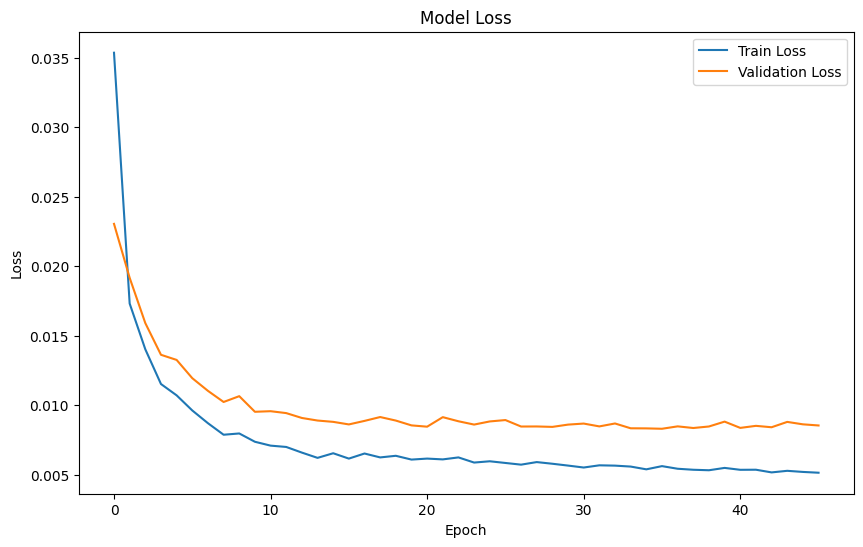

In [9]:
# --- 6. Train the Model ---
# EarlyStopping to stop training when a monitored metric has stopped improving.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
batch =  8
history = model.fit(X_train, Y_train,
                    epochs=100, # You can increase epochs, EarlyStopping will handle it
                    batch_size= batch ,
                    validation_split=0.2, # Use a portion of training data for validation
                    callbacks=[early_stopping],
                    verbose=1)

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [10]:
# --- 7. Evaluate the Model ---
train_loss = model.evaluate(X_train, Y_train, verbose=0)
test_loss = model.evaluate(X_test, Y_test, verbose=0)
print(f"\nTrain Loss (MSE): {train_loss:.4f}")
print(f"Test Loss (MSE): {test_loss:.4f}")


Train Loss (MSE): 0.0056
Test Loss (MSE): 0.0055


In [11]:
# --- 8. Make Predictions ---
# Make predictions on the test set
Y_pred_scaled = model.predict(X_test)

# Inverse transform the predictions and actual values to the original scale
Y_pred = scaler_target.inverse_transform(Y_pred_scaled)
Y_test_original = scaler_target.inverse_transform(Y_test.reshape(-1, 1))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(Y_test_original, Y_pred))
print(f"Test RMSE: {rmse:.4f}")

bias =np.mean( Y_pred- Y_test_original)
print(f"Test bias: { bias:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Test RMSE: 0.9901
Test bias: -0.2360


In [12]:
#Y_pred
#Y_test_original
#print(Y_pred .shape)
#df_cleaned[train_size:len(Y)]['Date']


dt_ys = df_cleaned[train_size:len(Y)]#['Date']
dt_ys['Y_pred'] = Y_pred
dt_ys['Y_test_original']= Y_test_original

dt_ys[['Date','Y_pred', 	'Y_test_original']]

dt_ys['Date'] = pd.to_datetime( dt_ys['Date'])

summer_df = dt_ys[ dt_ys['Date'].dt.month.isin([6, 7, 8])]

summer_df

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(summer_df['Y_test_original'], summer_df['Y_pred']))
print(f"Test RMSE: {rmse:.4f}")

Test RMSE: 0.9901


<ipython-input-12-65cb5f311b3e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_ys['Y_pred'] = Y_pred
<ipython-input-12-65cb5f311b3e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_ys['Y_test_original']= Y_test_original
<ipython-input-12-65cb5f311b3e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

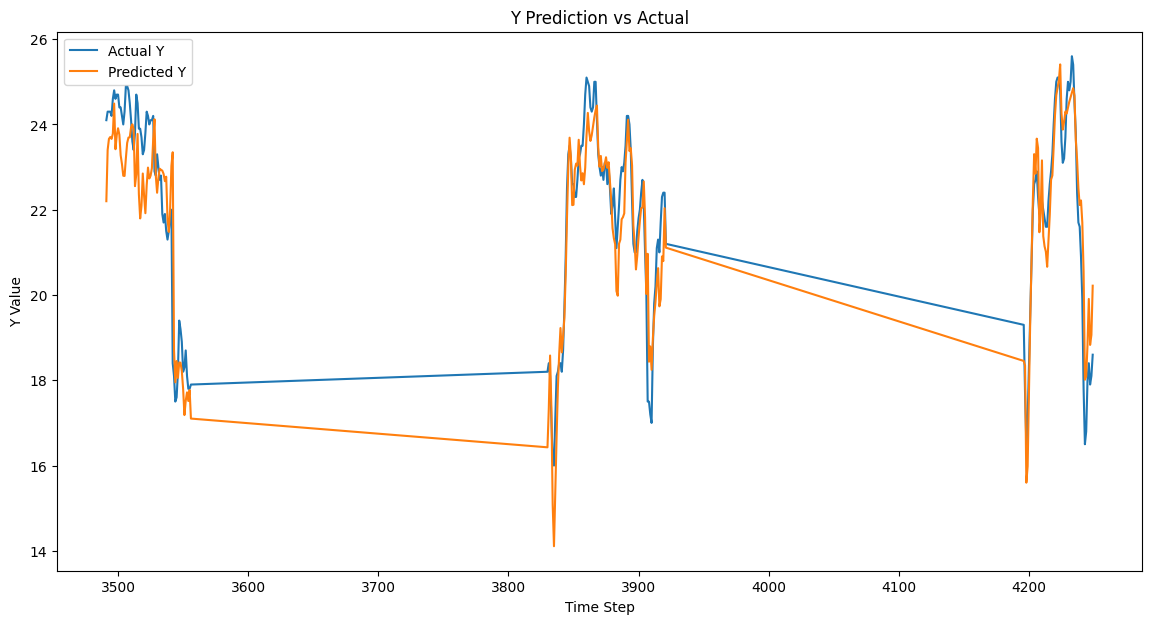

In [13]:
plt.figure(figsize=(14, 7))
plt.plot( summer_df['Y_test_original'], label='Actual Y')
plt.plot( summer_df['Y_pred'], label='Predicted Y')
plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

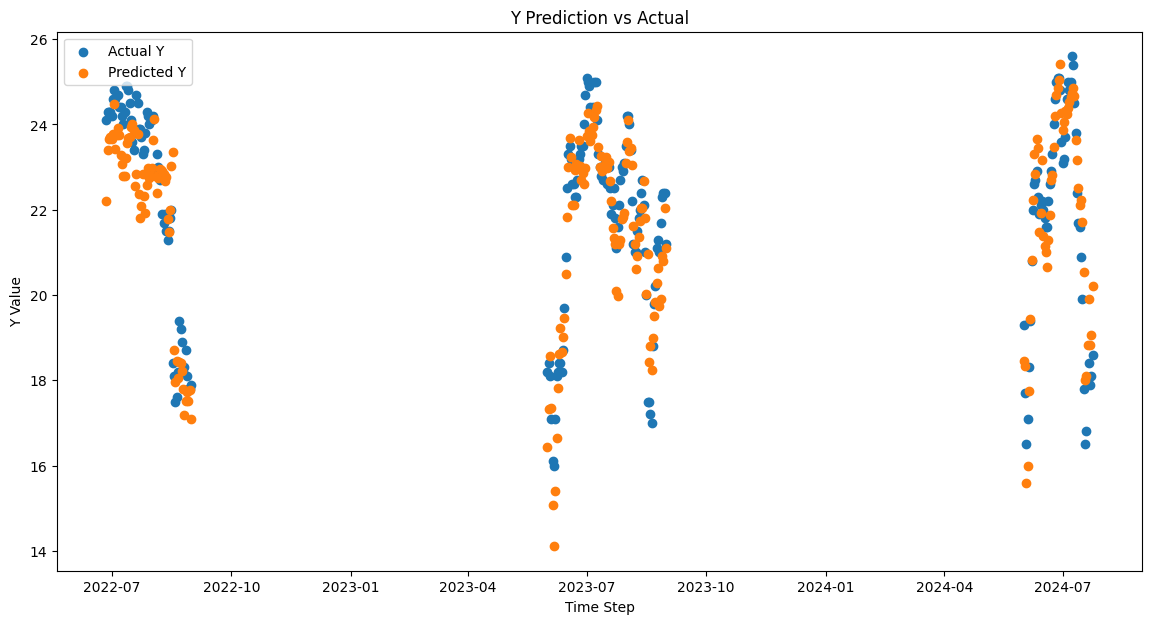

In [14]:
plt.figure(figsize=(14, 7))
plt.scatter(summer_df['Date'], summer_df['Y_test_original'], label='Actual Y')
plt.scatter(summer_df['Date'], summer_df['Y_pred'], label='Predicted Y')



plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

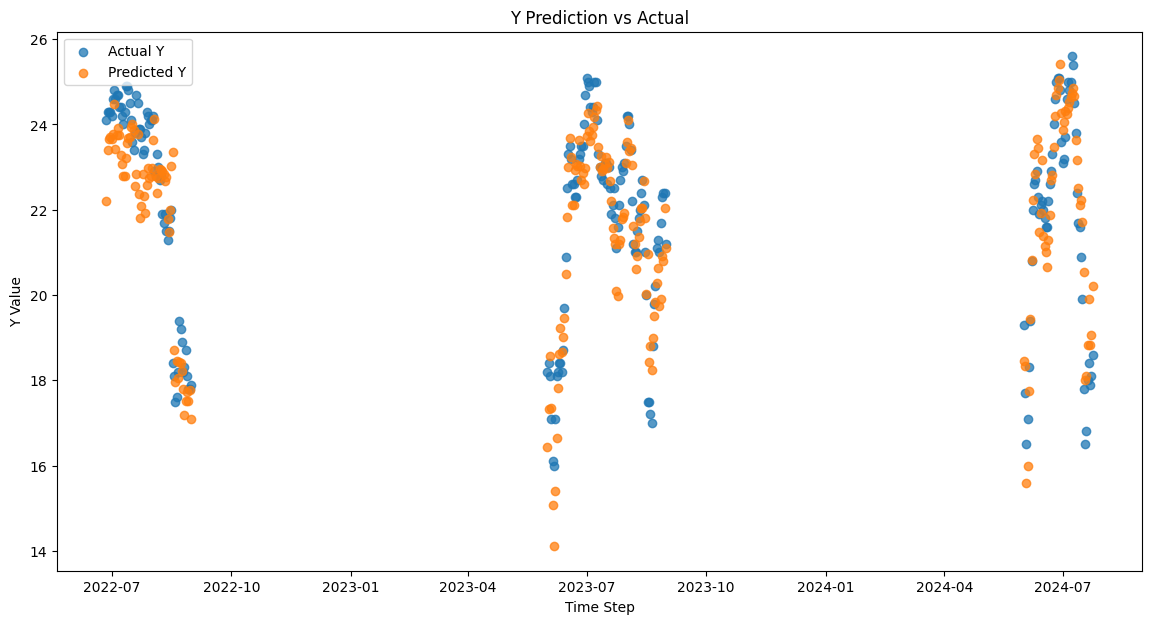

In [15]:
small= summer_df[0:256]
alpha=0.75
plt.figure(figsize=(14, 7))
plt.scatter( small['Date'],  small['Y_test_original'], label='Actual Y',alpha=alpha)
plt.scatter( small['Date'],  small['Y_pred'], label='Predicted Y',alpha=alpha)



plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

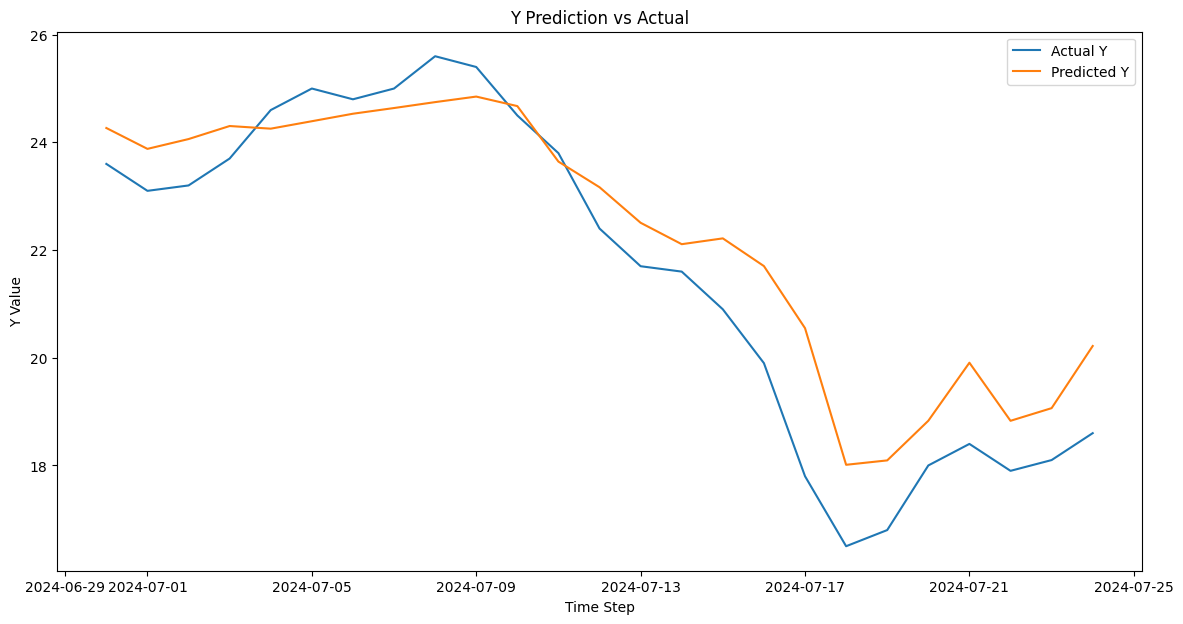

In [16]:
small= summer_df[187:256]

plt.figure(figsize=(14, 7))
plt.plot( small['Date'],  small['Y_test_original'], label='Actual Y')
plt.plot( small['Date'],  small['Y_pred'], label='Predicted Y')



plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

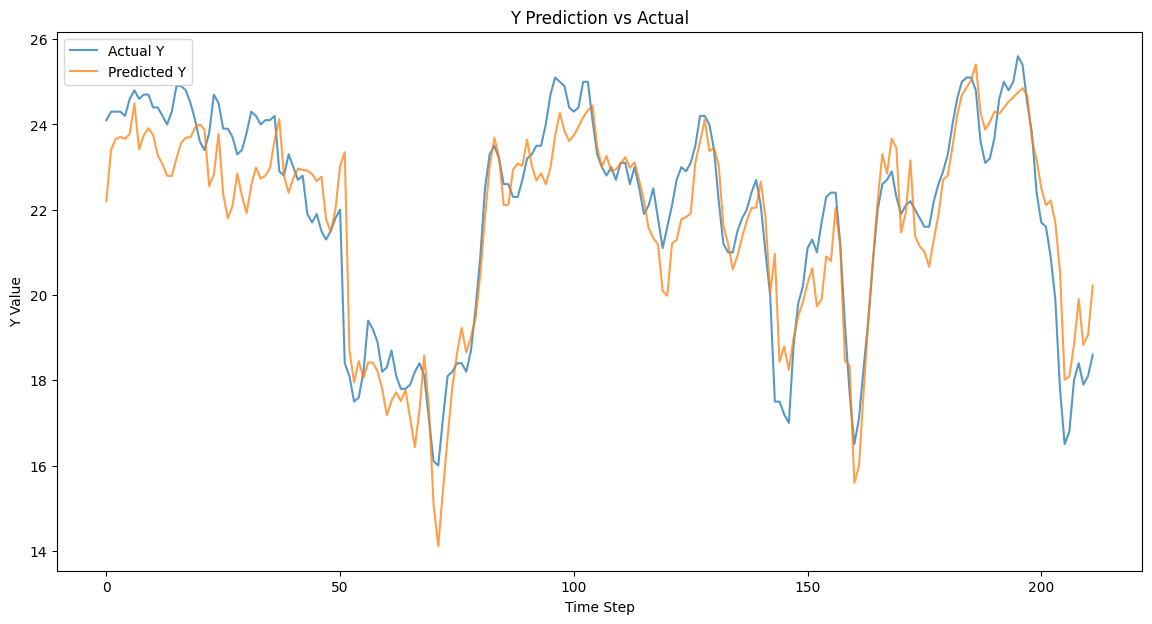

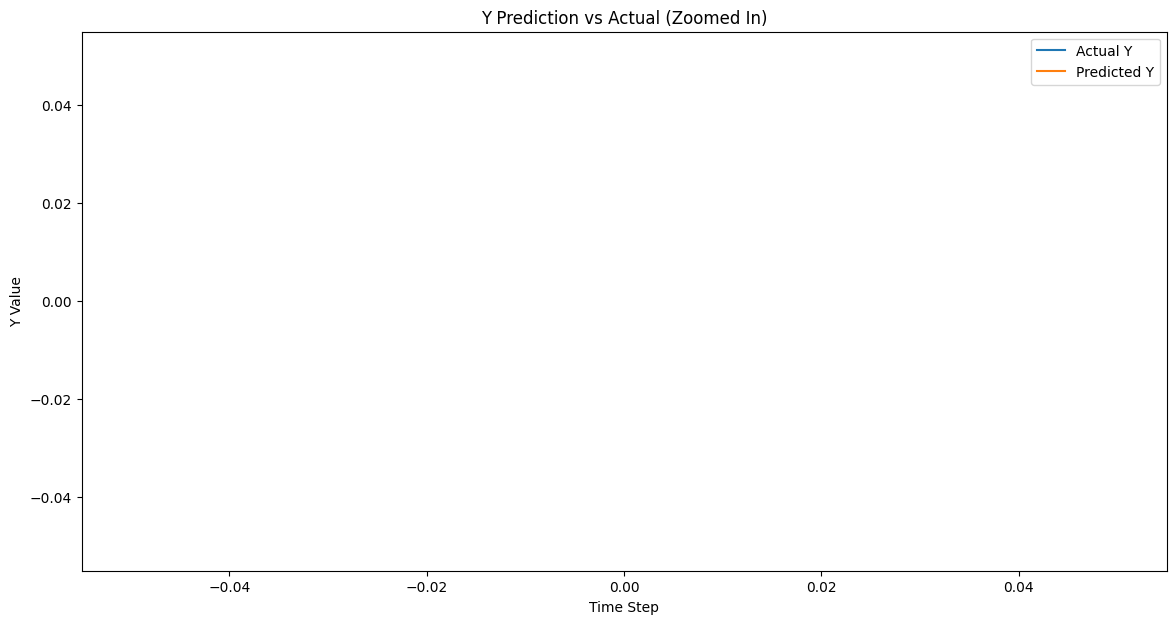

In [17]:



# --- 9. Visualize Predictions vs. Actual ---
plt.figure(figsize=(14, 7))
plt.plot(Y_test_original, label='Actual Y' ,alpha=alpha )
plt.plot(Y_pred, label='Predicted Y' ,alpha=alpha)
plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

# Optional: Plot a smaller segment for better detail
plt.figure(figsize=(14, 7))
plt.plot(Y_test_original[1234:1456], label='Actual Y')
plt.plot(Y_pred[ 1234:1456 ], label='Predicted Y')
plt.title('Y Prediction vs Actual (Zoomed In)')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

In [18]:

#print("h1:", h1)

#print(f"Test RMSE: {rmse:.4f}")



result_df = pd.DataFrame({
    "train_month" : [train_month]
   , "h1":[h1]
                          ,"h2":[h2]
                          ,"d1":[d1]
                          ,"d2":[d2]
                          ,"batch":[batch]
                          ,"look_back":[look_back]


                          ,"optimizer":[optimizer]
    ,'learning_rate':[learning_rate]
                          , "rmse":[rmse]
                           , "bias":[bias]})

print(result_df)


result_df.to_csv( model_site[0]+'result_df.csv' , index=False)


  train_month   h1  h2    d1     d2  batch  look_back  \
0   [6, 7, 8]  100  50  0.05  0.005      8         15   

                                           optimizer  learning_rate     rmse  \
0  <keras.src.optimizers.adam.Adam object at 0x7b...          0.001  0.99006   

       bias  
0 -0.235957  


In [19]:
model.save( (model_site[0]+'_lstm_model.h5') )

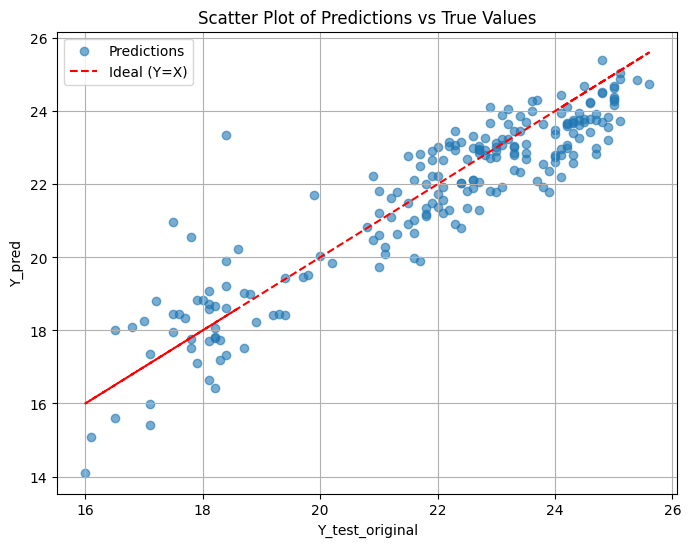

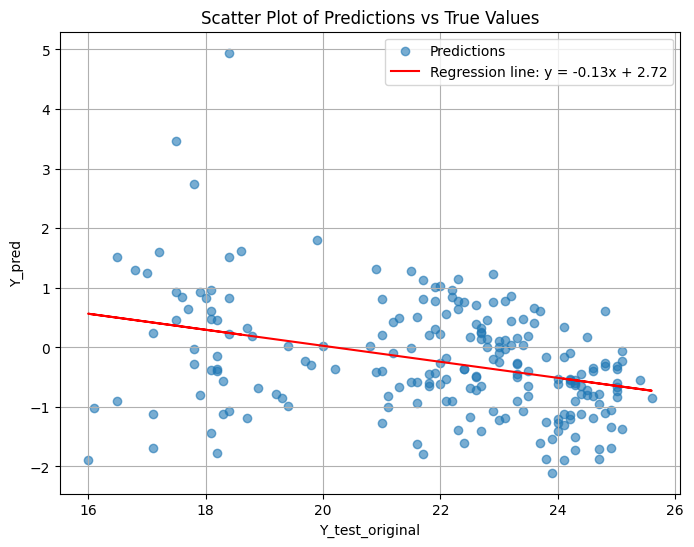

In [20]:
summer_df

# 1. Add a column "bias"
summer_df['bias'] = summer_df['Y_pred'] - summer_df['Y_test_original']

# 2. Scatter plot: x = Y_test_original, y = Y_pred
plt.figure(figsize=(8, 6))
plt.scatter( summer_df['Y_test_original'],  summer_df['Y_pred'], alpha=0.6, label='Predictions')
plt.plot( summer_df['Y_test_original'],  summer_df['Y_test_original'], color='red', linestyle='--', label='Ideal (Y=X)')
plt.xlabel('Y_test_original')
plt.ylabel('Y_pred')
plt.title('Scatter Plot of Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()

# 2. Scatter plot: x = Y_test_original, y = Y_pred
plt.figure(figsize=(8, 6))
plt.scatter( summer_df['Y_test_original'],  summer_df['bias'], alpha=0.6, label='Predictions')

# Calculate regression line
coefficients = np.polyfit(  summer_df['Y_test_original'],  summer_df['bias'] , 1)  # 1 for linear regression
polynomial = np.poly1d(coefficients)
y_pred = polynomial(  summer_df['Y_test_original']  )
# Plot regression line
plt.plot(  summer_df['Y_test_original'] , y_pred, color='red', label=f'Regression line: y = {coefficients[0]:.2f}x + {coefficients[1]:.2f}')


plt.xlabel('Y_test_original')
plt.ylabel('Y_pred')
plt.title('Scatter Plot of Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()

https://www.sciencedirect.com/science/article/pii/S2214581824000648#sec0030